In [15]:
import torch
from torch.utils.data import ConcatDataset, DataLoader, Dataset
import pickle
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torch.optim as optim

gnDataset = 3
gBase_path = 'CAS771/Task1_data'
gnClasses = 5
gbData_augmentation = False
gData_batch_size = 32

FDropout_rate = 0.7
Flearning_rate = 0.00001
FEpoch = 150
FWeight_decay = 1e-4
FnClasses = 15
Finput_dim = 465
FEarly_stop_patience = 15
FOpt_schedule_step = 10
FOpt_schedule_rate = 0.1

Ffusion_name = 'moefi'

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(torch.cuda.device_count())  # 사용 가능한 GPU 개수
print(torch.cuda.get_device_name(0))  # 첫 번째 GPU 이름

1
NVIDIA GeForce RTX 4090


In [23]:
train_data_paths = [f'{gBase_path}/Model{i}/model{i}_train.pth' for i in range(1, gnDataset+1)]
test_data_paths = [f'{gBase_path}/Model{i}/model{i}_test.pth' for i in range(1, gnDataset+1)]
print(train_data_paths)
print(test_data_paths)

class CAS771Dataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        if self.transform and not isinstance(img, torch.Tensor):
            img = self.transform(img)
        return img, label
    
def _load_data(train_data_path):
    raw_data = torch.load(train_data_path)
    data = raw_data['data']
    labels = raw_data['labels']
    return data, labels

def remap_labels(labels, class_mapping):
    return [class_mapping[label] for label in labels]

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_layers(model):
    layer_count = 0
    for module in model.children():
        if not isinstance(module, nn.Dropout):  # deduct Dropout
            layer_count += 1
    return layer_count

def get_model_instance(m = 0):
    model = torch.load(f"{gBase_path}/Model{m+1}/model{m+1}_all.pth")
    print(f"Model{m+1} parameters: {count_parameters(model)}")
    print(f"Model{m+1} Total layers: {count_layers(model)}")
    return model

def load_models():
    models = [get_model_instance(m) for m in range(gnDataset)]
    return models

def save_model(model, m=0, all=False):
    if all == True:
        model_saved_path = f"{gBase_path}/Model{m+1}/model{m+1}_all.pth"
        torch.save(model, model_saved_path)
    else:
        model_saved_path = f"{gBase_path}/Model{m+1}/model{m+1}_weights.pth"
        torch.save(model.state_dict(), model_saved_path)

    print(f"Model{m+1} is saved to: {model_saved_path}")

def get_data_augmentation(mode):
    if gbData_augmentation == False:
        return None
    
    if mode == "train":
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(), # inverse left-right
            transforms.RandomRotation(degrees=15), # random rotate
            transforms.RandomResizedCrop(32, scale=(0.8, 1.0)), # random crop
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # normalization
        ])
    else:
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

def _load_mappings():
    mapping_files = [f'{gBase_path}/Model{m+1}/class_mapping_model_{m+1}.pkl' for m in range(gnDataset)]
    rtov_mappings = {}
    vtor_mappings = {}

    i = 0
    for file in mapping_files:
        with open(file, 'rb') as f:
            mapping = pickle.load(f)
        
        offset = gnClasses*i
        rtov_mappings |= {key: value + offset for key, value in mapping.items()}
        vtor_mappings |= {value + offset: key for key, value in mapping.items()}
        i = i+1
        
    return rtov_mappings, vtor_mappings

def load_combined_dataset():
    rtov_mappings, vtor_mappings = _load_mappings()

    train_dataset = []
    test_dataset = []
    for m in range(gnDataset):
        train_data, train_labels = _load_data(train_data_paths[m])
        train_remapped_labels = remap_labels(train_labels, rtov_mappings)
        _train_dataset = CAS771Dataset(train_data, train_remapped_labels, transform=None)
        #_train_dataloader = DataLoader(train_dataset, batch_size=gData_batch_size, shuffle=True)

        test_data, test_labels = _load_data(test_data_paths[m])
        test_remapped_labels = remap_labels(test_labels, rtov_mappings)
        transform = get_data_augmentation("test")
        _test_dataset = CAS771Dataset(test_data, test_remapped_labels, transform=transform)
        #_test_dataloader = DataLoader(test_dataset, batch_size=gData_batch_size, shuffle=False)
        
        train_dataset.append(_train_dataset)
        test_dataset.append(_test_dataset)

    # 데이터셋 합치기
    combined_train_dataset = ConcatDataset(train_dataset)
    combined_test_dataset = ConcatDataset(test_dataset)

    # DataLoader 생성
    train_dataloader = DataLoader(combined_train_dataset, batch_size=gData_batch_size, shuffle=True)
    test_dataloader = DataLoader(combined_test_dataset, batch_size=gData_batch_size, shuffle=False)

    return train_dataloader, test_dataloader

class CAS771EarlyStopping():
    def __init__(self):
        self.best_val_loss = float('inf')
        self.patience_counter = 0

    def isStop(self, validation_loss):
        if validation_loss < self.best_val_loss: # 검증 손실이 감소하면 best_val_loss 업데이트
            self.best_val_loss = validation_loss
            self.patience_counter = 0
        else:
            self.patience_counter += 1
        
        if self.patience_counter >= FEarly_stop_patience: # 검증 손실이 감소하지 않으면 학습 종료
            print("Early stopping")
            return True
        else:
            return False



['CAS771/Task1_data/Model1/model1_train.pth', 'CAS771/Task1_data/Model2/model2_train.pth', 'CAS771/Task1_data/Model3/model3_train.pth']
['CAS771/Task1_data/Model1/model1_test.pth', 'CAS771/Task1_data/Model2/model2_test.pth', 'CAS771/Task1_data/Model3/model3_test.pth']


In [29]:
class FusionNetwork(nn.Module):
    def __init__(self, input_dim, output_dim=FnClasses):
        super(FusionNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)  # Batch Norm 추가
        self.fc2 = nn.Linear(256, 256)
        self.bn2 = nn.BatchNorm1d(256)  # Batch Norm 추가
        self.fc3 = nn.Linear(256, output_dim)
        self.dropout = nn.Dropout(FDropout_rate)

    def forward(self, x):
        x = self.dropout(F.relu(self.bn1(self.fc1(x))))  # BatchNorm 적용
        x = self.dropout(F.relu(self.bn2(self.fc2(x))))  # BatchNorm 적용
        x = self.fc3(x)
        return x

class MoE_Fusion(nn.Module):
    def __init__(self, input_dim, num_experts=5, hidden_dim=512, output_dim=FnClasses):
        super(MoE_Fusion, self).__init__()
        
        self.num_experts = num_experts
        
        # Gating network: 입력을 받아 각 전문가의 가중치를 결정
        self.gate = nn.Linear(input_dim, num_experts)

        # Expert networks: 개별 전문가 네트워크 (MLP 사용)
        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, output_dim)
            ) for _ in range(num_experts)
        ])

    def forward(self, x):
        # Gating network를 통해 expert 가중치 계산 (Softmax 적용)
        gate_scores = F.softmax(self.gate(x), dim=1)  # (batch_size, num_experts)

        # 각 expert의 예측값 계산
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=1)  # (batch_size, num_experts, output_dim)

        # Gating weight를 활용해 가중합
        gated_output = torch.sum(gate_scores.unsqueeze(2) * expert_outputs, dim=1)  # (batch_size, output_dim)

        return gated_output

class MoE_Fusion_Indv(nn.Module):
    def __init__(self, input_dims, num_experts=3, hidden_dim=512, output_dim=FnClasses, dropout_rate=0.5):  # output_dim 가정, dropout 추가
        super(MoE_Fusion_Indv, self).__init__()
        
        self.num_experts = num_experts
        self.input_dims = input_dims  # 각 입력 임베딩 벡터의 차원 리스트
        self.dropout_rate = dropout_rate
        
        # 각 입력에 대한 게이팅 네트워크
        self.gates = nn.ModuleList([
            nn.Linear(input_dim, num_experts) for input_dim in self.input_dims
        ])
        
        # 각 입력에 대한 전문가 네트워크
        self.experts = nn.ModuleList([
            nn.ModuleList([
              nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate),

                nn.Linear(hidden_dim, hidden_dim),  # 추가된 Hidden Layer
                nn.BatchNorm1d(hidden_dim),        # 추가된 Batch Norm
                nn.ReLU(),                          # 추가된 ReLU
                nn.Dropout(dropout_rate),          # 추가된 Dropout

                nn.Linear(hidden_dim, hidden_dim),  # 추가된 Hidden Layer
                nn.BatchNorm1d(hidden_dim),        # 추가된 Batch Norm
                nn.ReLU(),                          # 추가된 ReLU
                nn.Dropout(dropout_rate),          # 추가된 Dropout
                
                nn.Linear(hidden_dim, output_dim)
                ) for _ in range(num_experts)
            ]) for input_dim in self.input_dims
        ])
    
    def forward(self, inputs):  # inputs는 세 임베딩의 리스트
        
        # 각 입력에 대한 전문가 출력 계산
        expert_outputs_all = []
        for i, input_vector in enumerate(inputs):
            # 게이팅 네트워크 계산
            gate_scores = F.softmax(self.gates[i](input_vector), dim=1)  # (batch_size, num_experts)

            # 전문가 네트워크 계산
            expert_outputs = torch.stack([expert(input_vector) for expert in self.experts[i]], dim=1)  # (batch_size, num_experts, output_dim)

            # 게이팅 가중치 적용
            gated_output = torch.sum(gate_scores.unsqueeze(2) * expert_outputs, dim=1)  # (batch_size, output_dim)
            expert_outputs_all.append(gated_output)

        # 최종 출력
        # 예시로, 각 입력에 대한 expert 출력을 평균내는 방식으로 최종 출력 계산
        final_output = torch.mean(torch.stack(expert_outputs_all), dim=0)
        return final_output

In [4]:
def get_fusion_model(fusion_model_name, input_dim):
    if fusion_model_name == 'fnw':
        model = FusionNetwork(input_dim=input_dim).to(device)
    elif fusion_model_name == 'moef':
        model = MoE_Fusion(input_dim=input_dim).to(device)
    elif fusion_model_name == 'moefi':
        model = MoE_Fusion_Indv(input_dims=[Finput_dim]*3, dropout_rate=FDropout_rate).to(device)
    else:
        model = FusionNetwork(input_dim=input_dim).to(device)
    
    print(f"Fusion Model parameters: {count_parameters(model)}")
    print(f"FusionModel Total layers: {count_layers(model)}")

    optimizer = torch.optim.Adam(model.parameters(), lr=Flearning_rate, weight_decay=FWeight_decay)
    criterion = nn.CrossEntropyLoss()

    return model, optimizer, criterion

Training individual embeddings

In [5]:
# training individual embeddings
class CAS771Plot_E():
    def __init__(self, model, criterion, device, train_dataloader, test_dataloader, model_num, pre_models):
        self.model = model
        self.criterion = criterion 
        self.device = device
        self.train_losses = []
        self.validation_losses = []
        self.validation_accuracies = []
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.running_loss = 0.0
        self.model_num = model_num + 1
        self.pre_models = pre_models
    
    def init_running_loss(self):
        self.running_loss = 0.0

    def add_loss(self, loss):
        self.running_loss += loss

    def append(self, epoch):
        train_loss = self.running_loss / len(self.train_dataloader)
        validation_loss, validation_accuracy = self._validate()
        self.train_losses.append(train_loss)
        self.validation_losses.append(validation_loss)
        self.validation_accuracies.append(validation_accuracy)
        self._print(epoch, train_loss, validation_loss, validation_accuracy)
        return validation_loss

    def plot(self):
        self._plot_metrics(self.train_losses, self.validation_losses, self.validation_accuracies, self.model_num)
    
    def _print(self, epoch, train_loss, validation_loss, validation_accuracy):
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

    def _validate(self):
        self.model.eval()  # evaluation mode
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        
        with torch.no_grad():  # disable gradient calculations
            for inputs, labels in self.test_dataloader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                embeddings = []
                for model in models:
                    embedding = model(inputs, return_embedding=True).to(device)
                    embeddings.append(embedding)

                # Fusion Network에 입력
                outputs = fusion_model(embeddings)
                loss = criterion(outputs, labels)
                running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_samples += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()    
        
        validation_loss = running_loss / len(self.test_dataloader)
        validation_accuracy = correct_predictions / total_samples
        return validation_loss, validation_accuracy

    def _plot_metrics(self, train_losses, validation_losses, validation_accuracies, model_num):
        epochs = range(1, len(train_losses) + 1)

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses, label='Train Loss', marker='o')
        plt.plot(epochs, validation_losses, label='Validation Loss', marker='o')
        plt.title(f'Model {model_num} Learning per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(epochs, validation_accuracies, label='Validation Accuracy', marker='o', color='green')
        plt.title(f'Model {model_num} Accuracy per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show() 

In [21]:
train_data_paths = [f'{gBase_path}/Model{i}/model{i}_train.pth' for i in range(1, gnDataset+1)]
test_data_paths = [f'{gBase_path}/Model{i}/model{i}_test.pth' for i in range(1, gnDataset+1)]

def load_combined_dataset():
    rtov_mappings, vtor_mappings = _load_mappings()

    train_dataset = []
    test_dataset = []
    for m in range(gnDataset):
        train_data, train_labels = _load_data(train_data_paths[m])
        train_remapped_labels = remap_labels(train_labels, rtov_mappings)
        _train_dataset = CAS771Dataset(train_data, train_remapped_labels, transform=None)
        #_train_dataloader = DataLoader(train_dataset, batch_size=gData_batch_size, shuffle=True)
        train_dataset.append(_train_dataset)

    test_data, test_labels = _load_data(test_data_paths[0])
    test_remapped_labels = remap_labels(test_labels, rtov_mappings)
    transform = get_data_augmentation("test")
    _test_dataset = CAS771Dataset(test_data, test_remapped_labels, transform=transform)
    #_test_dataloader = DataLoader(test_dataset, batch_size=gData_batch_size, shuffle=False)
    test_dataset.append(_test_dataset)

    # 데이터셋 합치기
    combined_train_dataset = ConcatDataset(train_dataset)
    combined_test_dataset = ConcatDataset(test_dataset)

    # DataLoader 생성
    train_dataloader = DataLoader(combined_train_dataset, batch_size=gData_batch_size, shuffle=True)
    test_dataloader = DataLoader(combined_test_dataset, batch_size=gData_batch_size, shuffle=False)

    return train_dataloader, test_dataloader

Model1 parameters: 7993067
Model1 Total layers: 10
Model2 parameters: 7993067
Model2 Total layers: 10
Model3 parameters: 7993067
Model3 Total layers: 10
Fusion Model parameters: 6976233
FusionModel Total layers: 2
Epoch 1, Train Loss: 2.7074, Validation Loss: 2.6422, Validation Accuracy: 0.3793
Epoch 2, Train Loss: 2.6066, Validation Loss: 2.5563, Validation Accuracy: 0.5813
Epoch 3, Train Loss: 2.4809, Validation Loss: 2.4475, Validation Accuracy: 0.6133
Epoch 4, Train Loss: 2.3341, Validation Loss: 2.3011, Validation Accuracy: 0.6167
Epoch 5, Train Loss: 2.1691, Validation Loss: 2.1547, Validation Accuracy: 0.6207
Epoch 6, Train Loss: 1.9982, Validation Loss: 2.0187, Validation Accuracy: 0.6240
Epoch 7, Train Loss: 1.8351, Validation Loss: 1.8665, Validation Accuracy: 0.6267
Epoch 8, Train Loss: 1.6773, Validation Loss: 1.7531, Validation Accuracy: 0.6407
Epoch 9, Train Loss: 1.5250, Validation Loss: 1.6267, Validation Accuracy: 0.6427
Epoch 10, Train Loss: 1.3977, Validation Loss: 1

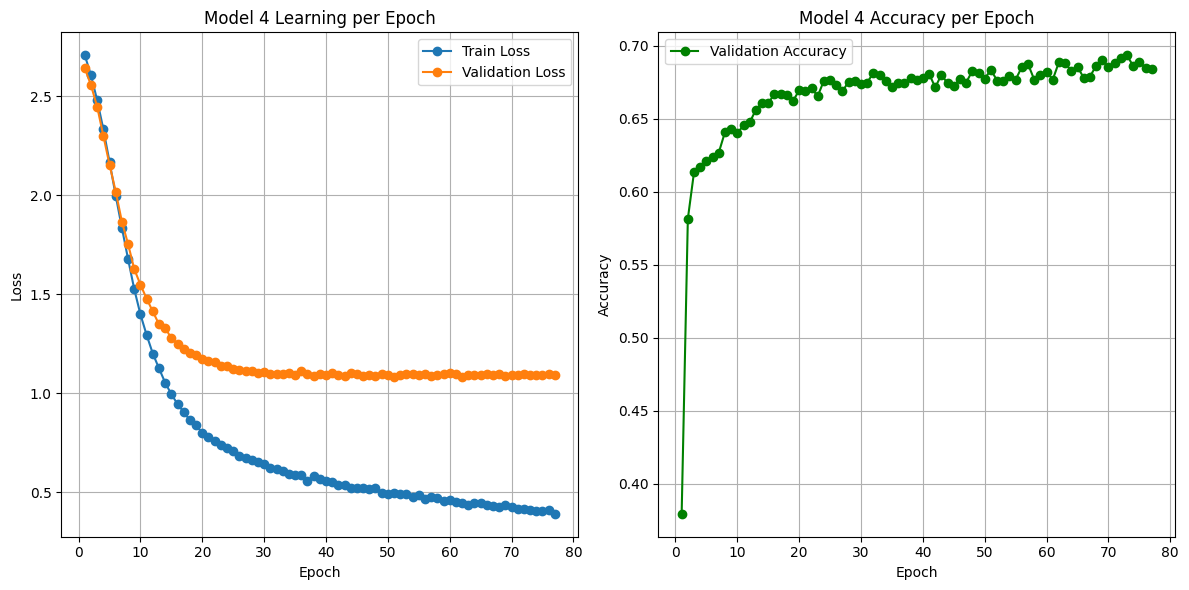

Model4 is saved to: CAS771/Task1_data/Model4/model4_all.pth


In [30]:
models = load_models()  # Load all models
fusion_model, optimizer, criterion = get_fusion_model(Ffusion_name, Finput_dim)
train_dataloader, test_dataloader = load_combined_dataset()

progress = CAS771Plot_E(fusion_model, criterion, device, train_dataloader, test_dataloader, 3, models)
es = CAS771EarlyStopping()

#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=FOpt_schedule_step, gamma=FOpt_schedule_rate) 

# train combine model
for epoch in range(FEpoch):
    fusion_model.train()
    total_loss = 0
    progress.init_running_loss()

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        embeddings = []
        for model in models:
            embedding = model(inputs, return_embedding=True).to(device)
            embeddings.append(embedding)

        # Fusion Network에 입력
        outputs = fusion_model(embeddings)
        loss = criterion(outputs, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        progress.add_loss(loss.item())

        total_loss += loss.item()
    
    if es.isStop(progress.append(epoch)):
        break 
    
    #scheduler.step() 
    
progress.plot()
save_model(fusion_model, 3, True)

del fusion_model
torch.cuda.empty_cache()

1. CNN1

In [8]:
class CNN(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        
        # Pooling layers
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        
        # Calculate the flattened size by passing dummy input
        dummy_input = torch.randn(1, 3, 32, 32)
        dummy_output = self.pool2(F.relu(self.bn3(self.conv3(self.pool1(F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(dummy_input)))))))))))
        flattened_size = dummy_output.view(1, -1).size(1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(flattened_size, 64)
        self.fc2 = nn.Linear(64, num_classes)
        
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)
       
    def forward(self, x, return_embedding=False):
        '''
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.pool1(x)
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.pool2(x)
        '''

        # Convolutional layer + ReLU + Batch Normalization
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x) # first pooling
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool2(x) # second pooling

        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers + Dropout
        embedding = self.dropout(F.relu(self.fc1(x)))

        if return_embedding:
            return embedding  # Feature vector 반환
        
        x = self.fc2(embedding)
        return x

2. CNN2

In [9]:
'''
gnGPU = "0"
gnDataset = 3
gBase_path = 'CAS771/Task1_data'
gnClasses = 5
gDropout_rate = 0.9
gBatch_momentum = 0.1
gLearning_rate = 0.00001
gWeight_decay = 1e-3
gOpt_Momentum = 0.9
gData_batch_size = 32
gEarly_stop_patience = 15
gnEpochs = 200
gbData_augmentation = False

'''
class CNN2(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(CNN2, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        
        # Pooling layers
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        
        # Calculate the flattened size by passing dummy input
        dummy_input = torch.randn(1, 3, 32, 32)
        dummy_output = self.pool2(F.relu(self.bn3(self.conv3(self.pool1(F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(dummy_input)))))))))))
        flattened_size = dummy_output.view(1, -1).size(1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(flattened_size, 465)
        self.fc2 = nn.Linear(465, num_classes)
        
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)
       
    def forward(self, x, return_embedding=False):
        # Convolutional layer + ReLU + Batch Normalization
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x) # first pooling
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool2(x) # second pooling
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers + Dropout
        x = self.dropout(F.relu(self.fc1(x)))

        if return_embedding:
            return x  # Feature vector 반환

        x = self.fc2(x)
        return x

Training with concatenating embedding vectors

In [11]:
'''
models = load_models()  # Load all models
fusion_model, optimizer, criterion = get_fusion_model(Ffusion_name, Finput_dim)
train_dataloader, test_dataloader = load_combined_dataset()

progress = CAS771Plot_E(fusion_model, criterion, device, train_dataloader, test_dataloader, 3, models)
es = CAS771EarlyStopping()

#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=FOpt_schedule_step, gamma=FOpt_schedule_rate) 

# train combine model
for epoch in range(FEpoch):
    fusion_model.train()
    total_loss = 0
    progress.init_running_loss()

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        embeddings = [model(inputs, return_embedding=True) for model in models]
        fused_input = torch.cat(embeddings, dim=1)  # Concatenate embeddings
        fused_input.to(device)

        outputs = fusion_model(fused_input)
        loss = criterion(outputs, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        progress.add_loss(loss.item())

        total_loss += loss.item()
    
    if es.isStop(progress.append(epoch)):
        break 
    
    #scheduler.step() 
    
progress.plot()
save_model(fusion_model, 3, True)

del fusion_model
torch.cuda.empty_cache()
'''

'\nmodels = load_models()  # Load all models\nfusion_model, optimizer, criterion = get_fusion_model(Ffusion_name, Finput_dim)\ntrain_dataloader, test_dataloader = load_combined_dataset()\n\nprogress = CAS771Plot_E(fusion_model, criterion, device, train_dataloader, test_dataloader, 3, models)\nes = CAS771EarlyStopping()\n\n#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=FOpt_schedule_step, gamma=FOpt_schedule_rate) \n\n# train combine model\nfor epoch in range(FEpoch):\n    fusion_model.train()\n    total_loss = 0\n    progress.init_running_loss()\n\n    for inputs, labels in train_dataloader:\n        inputs, labels = inputs.to(device), labels.to(device)\n\n        embeddings = [model(inputs, return_embedding=True) for model in models]\n        fused_input = torch.cat(embeddings, dim=1)  # Concatenate embeddings\n        fused_input.to(device)\n\n        outputs = fusion_model(fused_input)\n        loss = criterion(outputs, labels)\n\n        # Backpropagation\n        opti

In [ ]:
# embedding concatenate version
class CAS771Plot_E():
    def __init__(self, model, criterion, device, train_dataloader, test_dataloader, model_num, pre_models):
        self.model = model
        self.criterion = criterion 
        self.device = device
        self.train_losses = []
        self.validation_losses = []
        self.validation_accuracies = []
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.running_loss = 0.0
        self.model_num = model_num + 1
        self.pre_models = pre_models
    
    def init_running_loss(self):
        self.running_loss = 0.0

    def add_loss(self, loss):
        self.running_loss += loss

    def append(self, epoch):
        train_loss = self.running_loss / len(self.train_dataloader)
        validation_loss, validation_accuracy = self._validate()
        self.train_losses.append(train_loss)
        self.validation_losses.append(validation_loss)
        self.validation_accuracies.append(validation_accuracy)
        self._print(epoch, train_loss, validation_loss, validation_accuracy)
        return validation_loss

    def plot(self):
        self._plot_metrics(self.train_losses, self.validation_losses, self.validation_accuracies, self.model_num)
    
    def _print(self, epoch, train_loss, validation_loss, validation_accuracy):
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

    def _validate(self):
        self.model.eval()  # evaluation mode
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        
        with torch.no_grad():  # disable gradient calculations
            for inputs, labels in self.test_dataloader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                '''
                for model in models:
                    embedding = model(inputs, return_embedding=True)
                    embedding.to(device)

                    # Fusion Network에 입력
                    outputs = fusion_model(embedding)
                    loss = criterion(outputs, labels)
                    running_loss += loss.item()

                    _, predicted = torch.max(outputs, 1)
                    total_samples += labels.size(0)
                    correct_predictions += (predicted == labels).sum().item()
                '''
                # 개별 모델에서 embedding 추출
                embeddings = [model(inputs, return_embedding=True) for model in self.pre_models]
                fused_input = torch.cat(embeddings, dim=1)  # Concatenate embeddings
                fused_input.to(self.device)

                outputs = self.model(fused_input)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_samples += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()
                    
        
        validation_loss = running_loss / len(self.test_dataloader)
        validation_accuracy = correct_predictions / total_samples
        return validation_loss, validation_accuracy

    def _plot_metrics(self, train_losses, validation_losses, validation_accuracies, model_num):
        epochs = range(1, len(train_losses) + 1)

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses, label='Train Loss', marker='o')
        plt.plot(epochs, validation_losses, label='Validation Loss', marker='o')
        plt.title(f'Model {model_num} Learning per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(epochs, validation_accuracies, label='Validation Accuracy', marker='o', color='green')
        plt.title(f'Model {model_num} Accuracy per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()    